# Dropout and wider/deeper rwnet variants
For every test we follow the same structure:
1. Train 3 agents using the same architecture.
2. Plot the training performance combining the performance of all 3 agents.
3. Consider the performance of all 3 agents in the 50 predefined test worlds.
4. Determine the best performing agent by averaging across 50 predefined test worlds.
5. Compare with the other relevant architectures.
6. Decide on which setup to continue with, focusing on the best performers in most cases (but also taking the variance of the architecture into account).

In [1]:
from main import *
from training_evaluation import *
from rwnet_variations import *

#We define our training function
train = lambda obj, max_episodes = 150, policy = None : sarsa(obj, world_generator=dense_world, policy= policy, decay_factor=0.95, threshold=max_episodes-100, max_episodes=max_episodes, episode_duration=300)

In [2]:
#We have a number of worlds set aside for comparison
test_worlds = [dense_world() for i in range(50)]

#On each world we shall run an episode - this is our test function applied to the world and network. 
#We must allow custom policies (e.g. softmax).
test_single_world = lambda world, inet, policy: run_episode(world, inet, epsilon = 0, episode_duration = 300, policy=policy)

#To aggregate results we run our tests not on one world but many. 
#This allows us to compare agents after training in an exhaustive manner.
test = lambda inet, policy = None: [sum(test_single_world(world, inet, policy).rewards) for world in test_worlds]

## Differences in dropout
rwnet is very similar to wnet+, apart from using a different reflection symmetrization it does not use dropout. Let's see the effect of adding it in.

In [20]:
rwnet_fm = rw.gnet_fm

#This is exactly rwnet:
rwnet_gen_no_dropout = lambda : ModelPair(rw.LocalNet(SimpleLocalPathfinderNetWithDropout(7, dropout=0.0), radius = 7).to(device), rwnet_fm, 'rwnet', True)
#Tiny dropout:
rwnet_gen_tiny_dropout = lambda : ModelPair(rw.LocalNet(SimpleLocalPathfinderNetWithDropout(7, dropout=0.1), radius = 7).to(device), rwnet_fm, 'rwnet', True)
#Small dropout, akin to wnet+:
rwnet_gen_small_dropout = lambda : ModelPair(rw.LocalNet(SimpleLocalPathfinderNetWithDropout(7, dropout=0.2), radius = 7).to(device), rwnet_fm, 'rwnet', True)
#Moderate dropout:
rwnet_gen_moderate_dropout = lambda : ModelPair(rw.LocalNet(SimpleLocalPathfinderNetWithDropout(7, dropout=0.4), radius = 7).to(device), rwnet_fm, 'rwnet', True)

### No dropout: rwnet
(we retrain as we have been unable to keep data between training sessions)

In [4]:
rewards_df_rwnet, test_rewards_df_rwnet = run_training(rwnet_gen_no_dropout, train, test)

<ErrorbarContainer object of 3 artists>

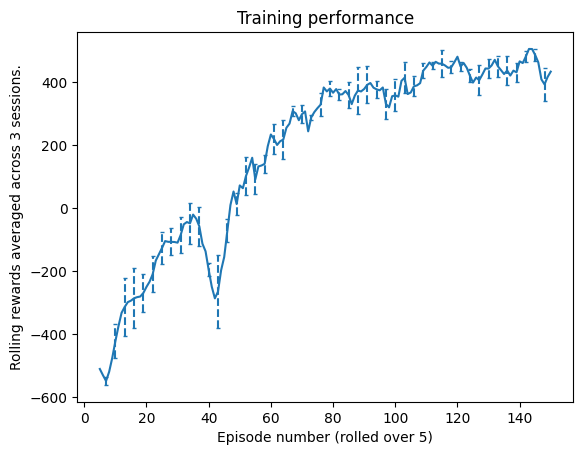

In [5]:
rolled_df_rwnet = roll_training_data(rewards_df_rwnet)
plot_training(rolled_df_rwnet, 150)

In [6]:
#We print the performance:
perf, mean_rwnet, err_rwnet = metrics(test_rewards_df_rwnet)

             Mean       Err.
Session 0  341.86  21.578447
Session 1  522.94  14.954882
Session 2  290.18  27.399697


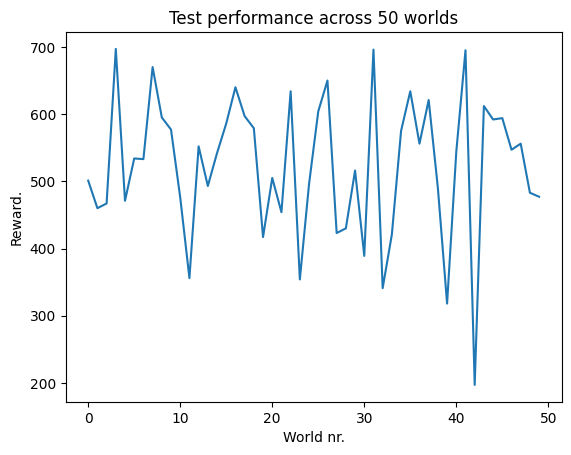

In [7]:
plot_test(test_rewards_df_rwnet, perf)

### 10% dropout

In [21]:
rewards_df_rwnet_p01, test_rewards_df_rwnet_p01 = run_training(rwnet_gen_tiny_dropout, train, test)

<ErrorbarContainer object of 3 artists>

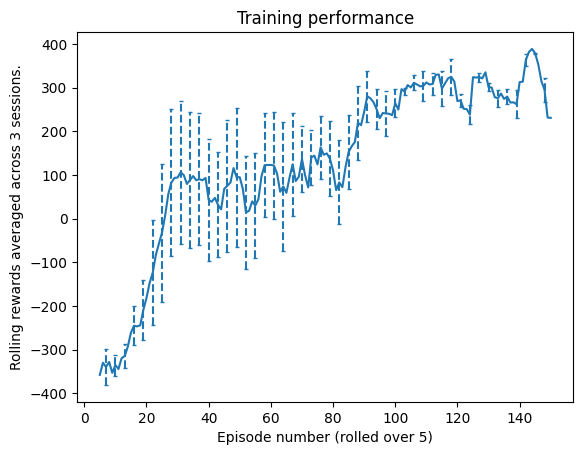

In [36]:
rolled_df_rwnet_p01 = roll_training_data(rewards_df_rwnet_p01)
plot_training(rolled_df_rwnet_p01, 150)

In [37]:
#We print the performance:
perf_p01, mean_rwnet_p01, err_rwnet_p01 = metrics(test_rewards_df_rwnet_p01)

             Mean       Err.
Session 0  466.78  17.974842
Session 1  508.98  18.435668
Session 2  413.46  18.120261


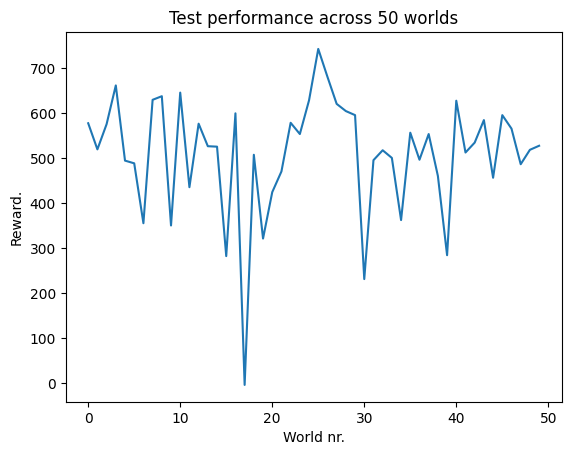

In [29]:
plot_test(test_rewards_df_rwnet_p01, perf_p01)

### 20% dropout
Same level of dropout as wnet and wnet+

In [8]:
rewards_df_rwnet_p02, test_rewards_df_rwnet_p02 = run_training(rwnet_gen_small_dropout, train, test)

<ErrorbarContainer object of 3 artists>

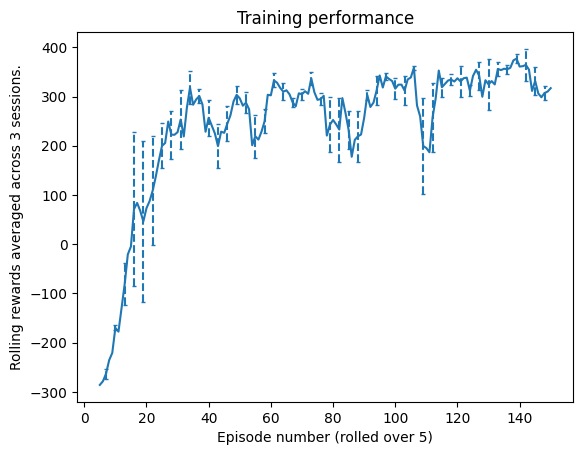

In [9]:
rolled_df_rwnet_p02 = roll_training_data(rewards_df_rwnet_p02)
plot_training(rolled_df_rwnet_p02, 150)

In [10]:
#We print the performance:
perf_p02, mean_rwnet_p02, err_rwnet_p02 = metrics(test_rewards_df_rwnet_p02)

             Mean       Err.
Session 0  464.18  40.290108
Session 1  463.06  36.449086
Session 2  402.20  42.501678


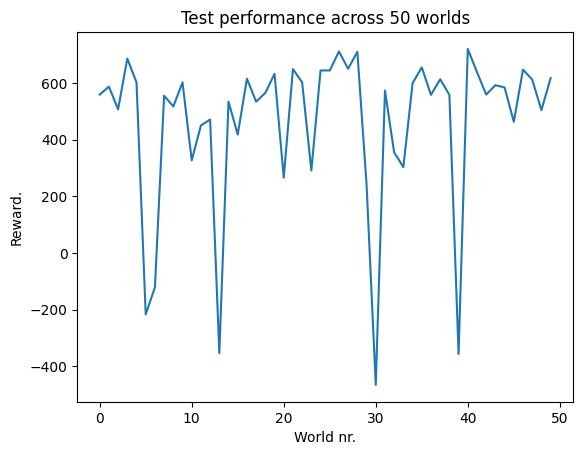

In [11]:
plot_test(test_rewards_df_rwnet_p02, perf_p02)

### 40% dropout

In [12]:
rewards_df_rwnet_p04, test_rewards_df_rwnet_p04 = run_training(rwnet_gen_moderate_dropout, train, test)

<ErrorbarContainer object of 3 artists>

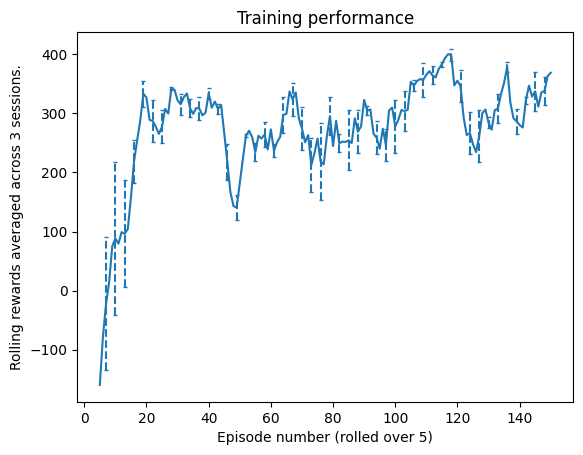

In [13]:
rolled_df_rwnet_p04 = roll_training_data(rewards_df_rwnet_p04)
plot_training(rolled_df_rwnet_p04, 150)

In [14]:
#We print the performance:
perf_p04, mean_rwnet_p04, err_rwnet_p04 = metrics(test_rewards_df_rwnet_p04)

             Mean       Err.
Session 0  426.92  38.730116
Session 1  403.10  41.334832
Session 2  422.80  44.355595


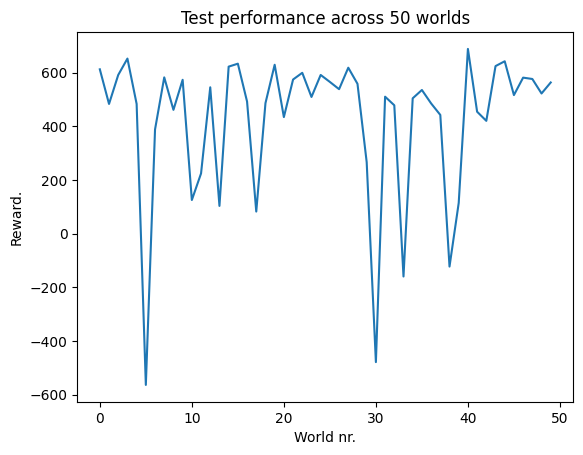

In [15]:
plot_test(test_rewards_df_rwnet_p04, perf_p04)

### Dropout comparison

#### Training comparison

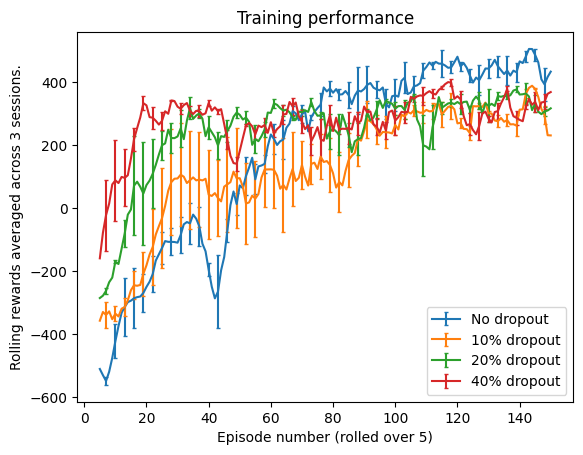

In [32]:
rolled_dfs = [rolled_df_rwnet, rolled_df_rwnet_p01, rolled_df_rwnet_p02, rolled_df_rwnet_p04]
names= ['No dropout', '10% dropout', '20% dropout', '40% dropout']
fp = multiplot_training(rolled_dfs, names, 150, sessions = 3, roll_nr = 5)
plt.savefig('dropout.png')
plt.show()

We see little to no difference in performance, though lower dropout means the agent takes longer to learn. Makes some sense, since the agent then behaves a bit more randomly (less affected by its bias). 

#### Test performance: Best agent

In [70]:
perf = pd.DataFrame()
perf['Means'] = [mean_rwnet, mean_rwnet_p01, mean_rwnet_p02 , mean_rwnet_p04]
perf['Std. Err'] =[err_rwnet, err_rwnet_p01, err_rwnet_p02, err_rwnet_p04]
perf.index = ['No dropout', '10% dropout', '20% dropout', '40% dropout']
perf.to_csv("dropout_perf.csv")
perf

,Means,Std. Err
No dropout,522.94,14.954882
10% dropout,508.98,18.435668
20% dropout,464.18,40.290108
40% dropout,426.92,38.730116


No dropout seems best. Note however that

1. The no dropout here seems very inconsistent and the best agent far outperforms what we saw in earlier experiments.
2. Had we measure by the mean then for example the 20% dropout agent would be considered to do better.
3. Looking at the test worlds and the graph for these, the best 'no-dropout' agent has no world for which it has a performance under 200, unlike the others.

In summary, the no-dropout network is less consistent (shows more variance in performance), but appears in this test to reach a higher maximum. This is by and large what we expect for employing regularization. For our experiments therefore it seems sensible to continue with 10% dropout since we are limited to a small amount of tests where need to strike a balance between peak performance and consistency.

## Deeper networks
We proceed with 10% dropout.

In [39]:
#One extra dense layer
rwnet_gen_deeper1 = lambda : ModelPair(rw.LocalNet(RW_deeper_1(7, dropout=0.1), radius = 7).to(device), rwnet_fm, 'rwnet_deep1', True)
#Two extra dense layers
rwnet_gen_deeper2 = lambda : ModelPair(rw.LocalNet(RW_deeper_2(7, dropout=0.1), radius = 7).to(device), rwnet_fm, 'rwnet_deep2', True)

### One extra dense layer

In [40]:
rewards_df_rwnet_deeper1, test_rewards_df_rwnet_deeper1 = run_training(rwnet_gen_deeper1, train, test)

<ErrorbarContainer object of 3 artists>

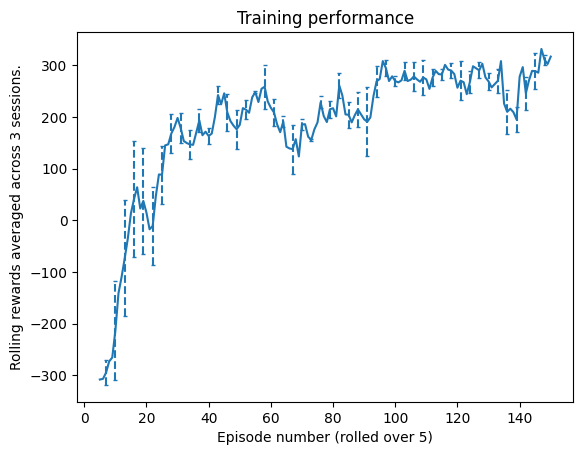

In [41]:
rolled_df_rwnet_deeper1 = roll_training_data(rewards_df_rwnet_deeper1)
plot_training(rolled_df_rwnet_deeper1, 150)

In [42]:
#We print the performance:
perf_deeper1, mean_deeper1, err_rwnet_deeper1 = metrics(test_rewards_df_rwnet_deeper1)

             Mean       Err.
Session 0  396.34  29.320684
Session 1  480.20  37.434787
Session 2  187.26  38.368246


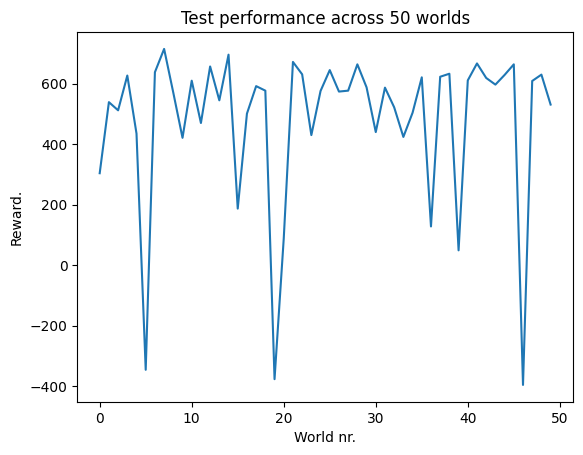

In [43]:
plot_test(test_rewards_df_rwnet_deeper1, perf_deeper1)

### Two extra dense layers

In [44]:
rewards_df_rwnet_deeper2, test_rewards_df_rwnet_deeper2 = run_training(rwnet_gen_deeper2, train, test)

<ErrorbarContainer object of 3 artists>

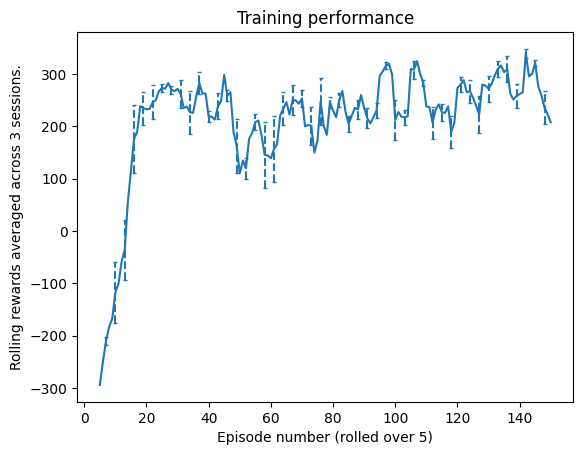

In [45]:
rolled_df_rwnet_deeper2 = roll_training_data(rewards_df_rwnet_deeper2)
plot_training(rolled_df_rwnet_deeper2, 150)

In [46]:
#We print the performance:
perf_deeper2, mean_deeper2, err_rwnet_deeper2 = metrics(test_rewards_df_rwnet_deeper2)

             Mean       Err.
Session 0  273.08  54.210661
Session 1  406.40  39.870638
Session 2  235.94  44.977386


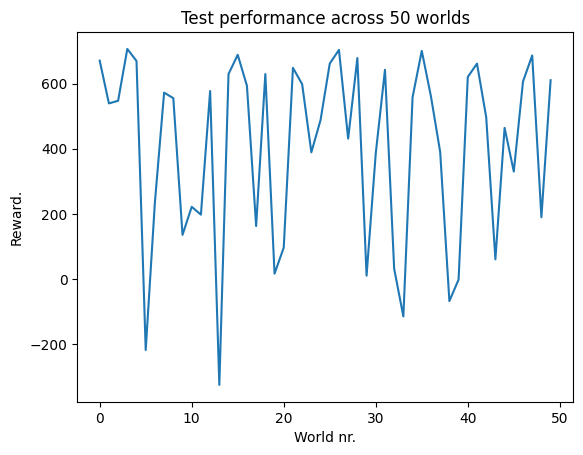

In [47]:
plot_test(test_rewards_df_rwnet_deeper2, perf_deeper2)

### Depth comparison

#### Training comparison

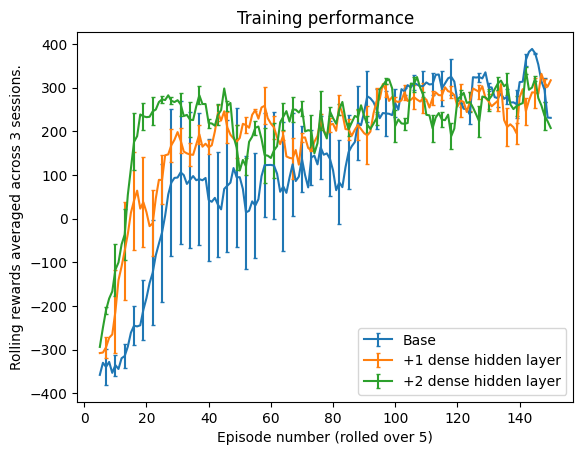

In [50]:
rolled_dfs = [rolled_df_rwnet_p01, rolled_df_rwnet_deeper1, rolled_df_rwnet_deeper2]
names= ['Base', '+1 dense hidden layer', '+2 dense hidden layer']
fp = multiplot_training(rolled_dfs, names, 150, sessions = 3, roll_nr = 5)
plt.savefig('depth.png')
plt.show()

#### Test performance: Best agent

In [53]:
perf = pd.DataFrame()
perf['Means'] = [mean_rwnet_p01, mean_deeper1, mean_deeper2]
perf['Std. Err'] =[err_rwnet_p01, err_rwnet_deeper1, err_rwnet_deeper2]
perf.index = ['Base', '+1 dense hidden layer', '+2 dense hidden layer']
perf.to_csv("depth_perf.csv")
perf

,Means,Std. Err
Base,508.98,18.435668
+1 dense hidden layer,480.20,37.434787
+2 dense hidden layer,406.40,39.870638


No extra layers seems best. The other networks plateau faster but even their best agents are quite inconsistent, and their lesser agents are also quite poor performers. However, it could be that the layers are deeper without being sufficiently wide.

## Wider networks

In [59]:
#One extra dense layer
rwnet_gen_wider = lambda : ModelPair(rw.LocalNet(RW_wider(7, dropout=0.1), radius = 7).to(device), rwnet_fm, 'rwnet_wider', True)
#Two extra dense layers
rwnet_gen_wider_deeper = lambda : ModelPair(rw.LocalNet(RW_wider_deeper(7, dropout=0.1), radius = 7).to(device), rwnet_fm, 'rwnet_wider_deeper', True)

### Wider/deeper hidden layer

In [60]:
rewards_df_rwnet_wider, test_rewards_df_rwnet_wider = run_training(rwnet_gen_wider, train, test)

<ErrorbarContainer object of 3 artists>

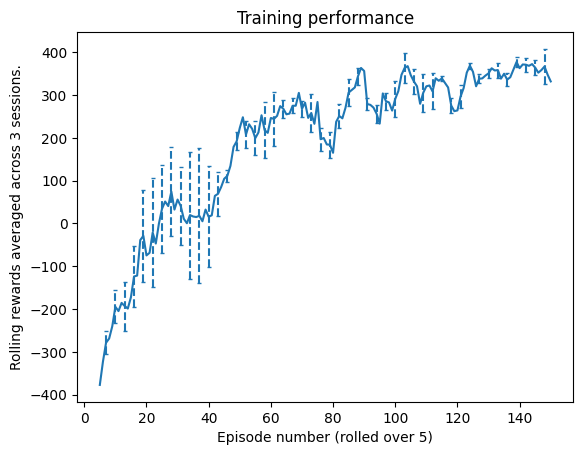

In [61]:
rolled_df_rwnet_wider = roll_training_data(rewards_df_rwnet_wider)
plot_training(rolled_df_rwnet_wider, 150)

In [62]:
#We print the performance:
perf_wider, mean_rwnet_wider, err_rwnet_wider = metrics(test_rewards_df_rwnet_wider)

             Mean       Err.
Session 0  281.64  38.486963
Session 1  331.92  48.117932
Session 2  444.96  16.515792


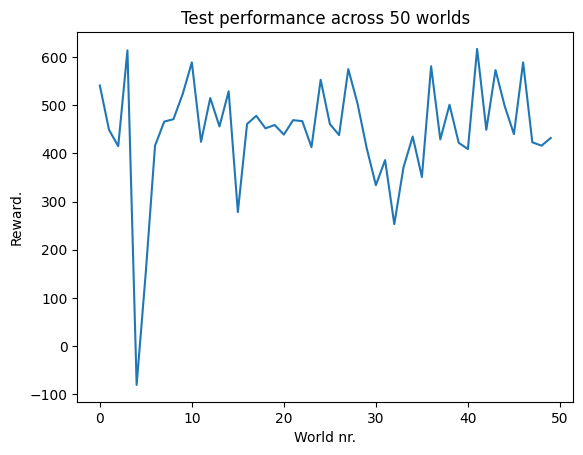

In [63]:
plot_test(test_rewards_df_rwnet_wider, perf_wider)

### Wider and deeper hidden layers

In [64]:
rewards_df_rwnet_wider_deeper, test_rewards_df_rwnet_wider_deeper = run_training(rwnet_gen_wider_deeper, train, test)

<ErrorbarContainer object of 3 artists>

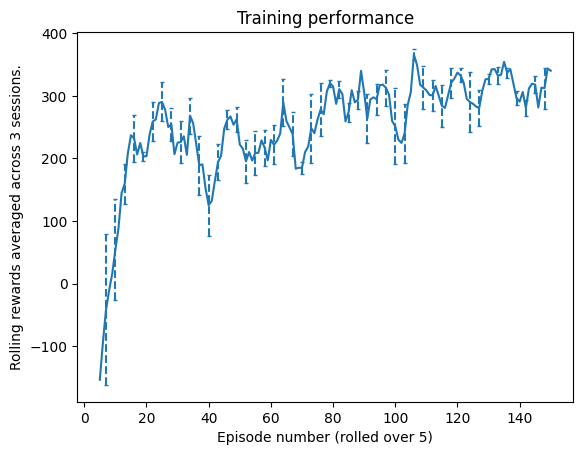

In [65]:
rolled_df_rwnet_wider_deeper = roll_training_data(rewards_df_rwnet_wider_deeper)
plot_training(rolled_df_rwnet_wider_deeper, 150)

In [66]:
#We print the performance:
perf_wider_deeper, mean_rwnet_wider_deeper, err_rwnet_wider_deeper = metrics(test_rewards_df_rwnet_wider_deeper)

             Mean       Err.
Session 0  292.58  57.859309
Session 1  281.94  47.713579
Session 2  262.32  40.832634


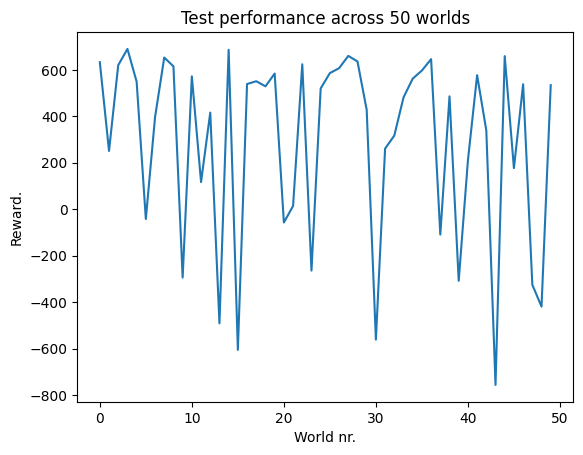

In [67]:
plot_test(test_rewards_df_rwnet_wider_deeper, perf_wider_deeper)

### Width/depth comparison

#### Training comparison

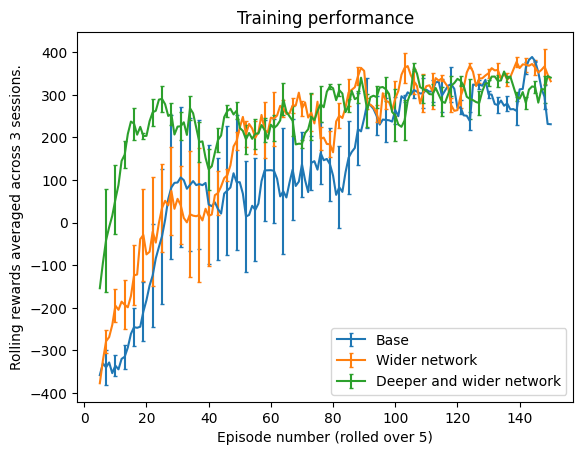

In [68]:
rolled_dfs = [rolled_df_rwnet_p01, rolled_df_rwnet_wider, rolled_df_rwnet_wider_deeper]
names= ['Base', 'Wider network', 'Deeper and wider network']
fp = multiplot_training(rolled_dfs, names, 150, sessions = 3, roll_nr = 5)
plt.savefig('width.png')
plt.show()

#### Test performance: Best agent

In [69]:
perf = pd.DataFrame()
perf['Means'] = [mean_rwnet_p01, mean_rwnet_wider, mean_rwnet_wider_deeper]
perf['Std. Err'] =[err_rwnet_p01, err_rwnet_wider, err_rwnet_wider_deeper]
perf.index = ['Base', 'Wider network', 'Deeper and wider network']
perf.to_csv("width_perf.csv")
perf

,Means,Std. Err
Base,508.98,18.435668
Wider network,444.96,16.515792
Deeper and wider network,292.58,57.859309


No extra layers or wider layers seems best. It could be argued that we should have searched for optimal dropout for these architectures independently.